In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from image_loader.load_tagged_image import load_tagged_image, convert_image_file_to_numpy, load_tagged_points_only
import os
import Global_Constants
import tqdm
import scipy.io

Load The Images and tag locations

In [12]:
# the minimal distance between tagged points that we allow
minimal_distance_between_tagged_points = 5
images = []
tagged = []
def load_images(normalization_quantiles=None):
    global images, tagged
    images = []
    tagged = []
    images_dir = "images\\tagged_images"
    for dir_name in tqdm.tqdm(os.listdir(images_dir)):
        dir_path = os.path.join(images_dir,dir_name)
        im,tags = load_tagged_image(dir_path,normalization_quantiles)
        
        # remove tagged points that are to close to one another
        x_matrix = np.stack([tags[:,0] for i in range(tags.shape[0])]).astype(float)
        y_matrix = np.stack([tags[:,1] for i in range(tags.shape[0])]).astype(float)
        z_matrix = np.stack([tags[:,2] for i in range(tags.shape[0])]).astype(float)
        dx_matrix = x_matrix-x_matrix.T
        dy_matrix = y_matrix-y_matrix.T
        dz_matrix = 2*(z_matrix-z_matrix.T)
        dist_matrix = np.sqrt(dx_matrix**2 + dy_matrix**2 + dz_matrix**2)
        dist_matrix[dist_matrix == 0] = 10000
        dist_min = np.min(dist_matrix,axis=0)
        # plt.hist(dist_min.flatten(),bins=np.linspace(0,10),alpha=0.4,label=dir_name)
        tags = tags[dist_min >= minimal_distance_between_tagged_points]
        
        images.append(im)
        tagged.append(tags)
load_images()


100%|██████████| 4/4 [00:07<00:00,  1.93s/it]


Draw tha images and tagged data, z is projected via maximum on z, only the chanel with the data is drawn.

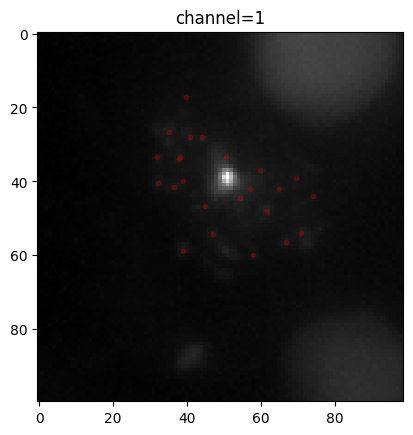

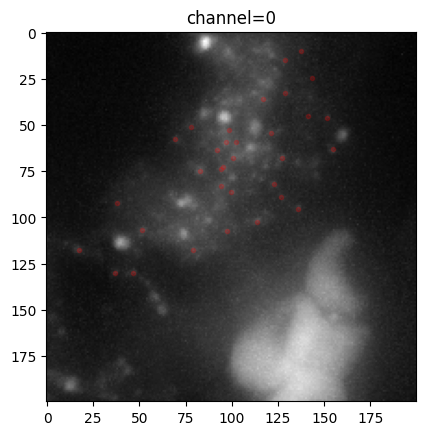

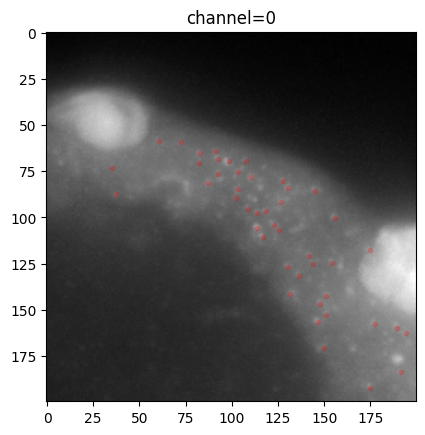

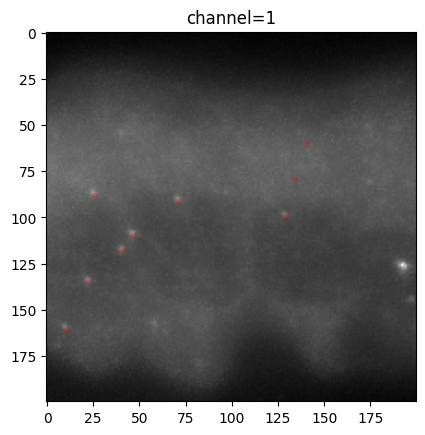

In [13]:
for i in range(len(images)):
    plt.figure()
    ch = int(tagged[i][3,3])
    plt.imshow(np.max(images[i][:,:,:,ch],axis=-1),cmap="gray")
    plt.plot(tagged[i][:,0],tagged[i][:,1],".r",alpha=0.2)
    plt.title(f"channel={ch}")

Find Dot Parameters/Moments

In [14]:
def get_small_images_around_points(image_index,z_span=1,xy_span=5, assert_size=True):
    sml_imges = []
    sml_imges_point_loc = []
    for pt_idx,point in enumerate(tagged[image_index]):
        im = images[image_index]
        sml_img = im[
                int(round(point[1])) - xy_span:int(round(point[1])) + xy_span + 1,
                int(round(point[0])) - xy_span:int(round(point[0])) + xy_span + 1,
                int(point[2]) - z_span:int(point[2]) + z_span + 1,
                int(point[3])
                    ]
        if assert_size :
            if sml_img.shape != (xy_span*2+1,xy_span*2+1,z_span*2+1):
                continue
        else:
            if np.size(sml_img) == 0:
                continue
        sml_imges.append(sml_img)
        sml_imges_point_loc.append((
        point[1] - (int(round(point[1])) - xy_span),
        point[0] - (int(round(point[0])) - xy_span)))
    return sml_imges,sml_imges_point_loc

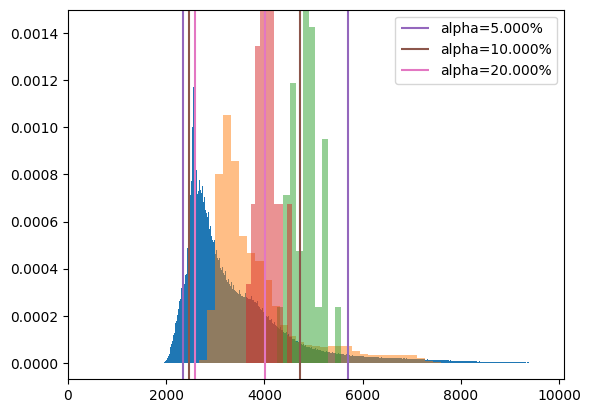

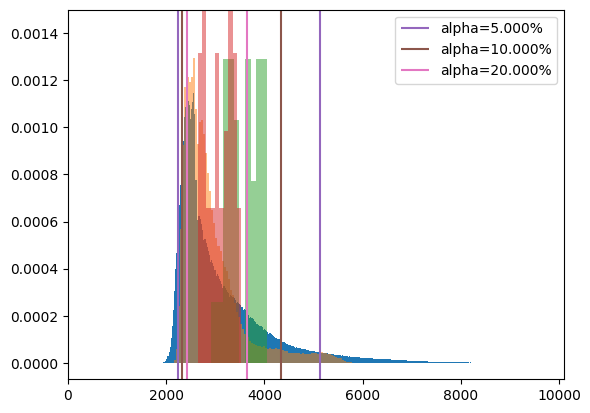

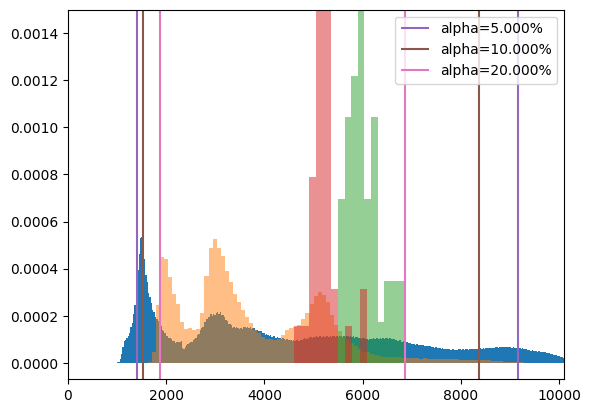

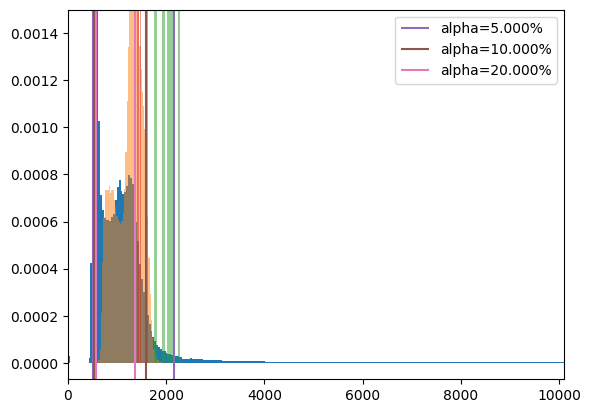

In [15]:
z_span = 1
xy_span = 5
for i in range(1,5):
    plt.figure()
    dir_path = f"images\\tagged_images\\img{i}"
    image_file_path = os.path.join(dir_path, "image.tif")
    tagged_points_path = os.path.join(dir_path, "Results.csv")
    try:
        original_big_image_file_path = os.path.join(dir_path, "OG_Big_Image.nd2")
        original_big_image_array = convert_image_file_to_numpy(original_big_image_file_path)
    except:
        original_big_image_file_path = os.path.join(dir_path, "OG_Big_Image.tif")
        original_big_image_array = convert_image_file_to_numpy(original_big_image_file_path)
    tagged_points = load_tagged_points_only(tagged_points_path)
    image_array = convert_image_file_to_numpy(image_file_path)
    
    
    sml_imges = []
    sml_imges_point_loc = []
    for pt_idx,point in enumerate(tagged_points):
        im = image_array
        sml_img = im[
                int(round(point[1])) - xy_span:int(round(point[1])) + xy_span + 1,
                int(round(point[0])) - xy_span:int(round(point[0])) + xy_span + 1,
                int(point[2]) - z_span:int(point[2]) + z_span + 1,
                int(point[3])
                    ]
        if sml_img.shape != (xy_span*2+1,xy_span*2+1,z_span*2+1):
            continue
        sml_imges.append(sml_img)
        sml_imges_point_loc.append((
        point[1] - (int(round(point[1])) - xy_span),
        point[0] - (int(round(point[0])) - xy_span)))
    sml_imges = np.array(sml_imges)

    intensity = []
    background_intensity_around_points = []
    for sml_img in sml_imges:
        x,y,z = sml_img.shape[0]//2,sml_img.shape[1]//2,sml_img.shape[2]//2
        spot_region = sml_img[x-1:x+2,y-1:y+2,z-1:z+2]
        not_background_region = sml_img[x-2:x+3,y-2:y+3,z-2:z+3]
        spot_intensity = np.max(spot_region)
        background_intensity = (np.sum(sml_img) - np.sum(not_background_region)) / (np.size(sml_img)-np.size(not_background_region))
        intensity.append(spot_intensity)
        background_intensity_around_points.append(background_intensity)
    
    ch = int(tagged_points[3,3])
    plt.hist(original_big_image_array[...,ch].flatten(),bins=1000,density=True)
    plt.hist(image_array[...,ch].flatten(),bins=100,density=True,alpha=0.5)
    plt.hist(intensity,bins=10,alpha=0.5,density=True)
    plt.hist(background_intensity_around_points,bins=10,alpha=0.5,density=True)
    for alpha in [5,10,20]:
        color = next(plt.gca()._get_lines.prop_cycler)
        plt.vlines(np.percentile(original_big_image_array[...,ch].flatten(),(alpha,100-alpha)),-1,100,label=f"alpha={alpha:.3f}%",**color)
    plt.xlim(0,10100)
    plt.ylim(-0.00007,0.0015)
    plt.legend()

Find Dot Intencity Distribution

In [16]:
def draw_histograms_of_intensities(b_draw_slices = True,title=""):
    z_span = 1
    xy_span = 5
    hist_residual_fig = plt.figure()
    hist_residual_ax = hist_residual_fig.gca()
    hist_nominal_fig = plt.figure()
    hist_nominal_ax = hist_nominal_fig.gca()
    residual_intensity_arrays = []
    for i in range(len(images)):
        # sml_imges = np.full((tagged[i].shape[0],10,10,4),np.nan)
        sml_imges,sml_imges_point_loc = get_small_images_around_points(image_index=i,z_span=z_span,xy_span=xy_span)

        intensity = []
        residual_intensity = []
        for sml_img in sml_imges:
            x,y,z = sml_img.shape[0]//2,sml_img.shape[1]//2,sml_img.shape[2]//2
            spot_region = sml_img[x-1:x+2,y-1:y+2,z-1:z+2]
            not_background_region = sml_img[x-2:x+3,y-2:y+3,z-2:z+3]
            spot_intensity = np.max(spot_region)
            background_intensity = (np.sum(sml_img) - np.sum(not_background_region)) / (np.size(sml_img)-np.size(not_background_region))
            intensity.append(spot_intensity)
            residual_intensity.append(spot_intensity - background_intensity)
        residual_intensity_arrays.append(residual_intensity)
        color = next(hist_residual_ax._get_lines.prop_cycler)
        hist_residual_ax.hist(residual_intensity,bins=5,alpha=0.5,**color, label=f"{i}",density=True)
        hist_residual_ax.plot(residual_intensity,[-i*0.0001]*len(residual_intensity),marker="o",linestyle="",**color)
        color = next(hist_nominal_ax._get_lines.prop_cycler)
        hist_nominal_ax.hist(intensity,bins=5,alpha=0.5,**color, label=f"{i}",density=True)
        hist_nominal_ax.plot(intensity,[-i*0.0001]*len(intensity),marker="o",linestyle="",**color)
        

        if b_draw_slices:
            _,axes = plt.subplots(3,8)
            axes = axes.flatten()
            for j in range(len(axes)):
                try:
                    axes[j].imshow(np.max(sml_imges[j],axis=-1),vmax=2,vmin=-3,cmap="gray")
                    axes[j].plot(sml_imges_point_loc[j][0],sml_imges_point_loc[j][1],"xr",alpha=0.5)
                    
                except:
                    pass
    
    hist_nominal_ax.legend()
    hist_nominal_ax.set_title("total intensity, " + title)
    hist_residual_ax.legend()
    hist_residual_ax.set_title("residual intensity, " + title)
    return hist_residual_fig, hist_nominal_fig, residual_intensity_arrays

(array([ 7., 23., 27., 18., 11.,  5.,  3.,  1.,  0.,  2.]),
 array([ 283.32248521,  416.09704142,  548.87159763,  681.64615385,
         814.42071006,  947.19526627, 1079.96982249, 1212.7443787 ,
        1345.51893491, 1478.29349112, 1611.06804734]),
 <BarContainer object of 10 artists>)

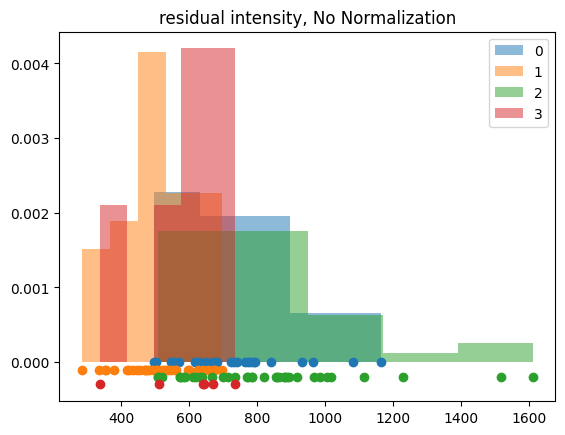

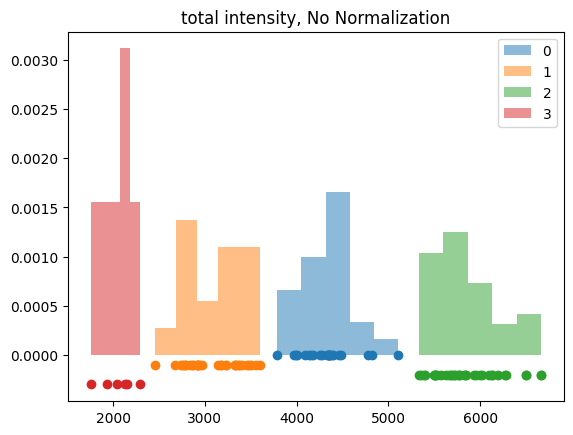

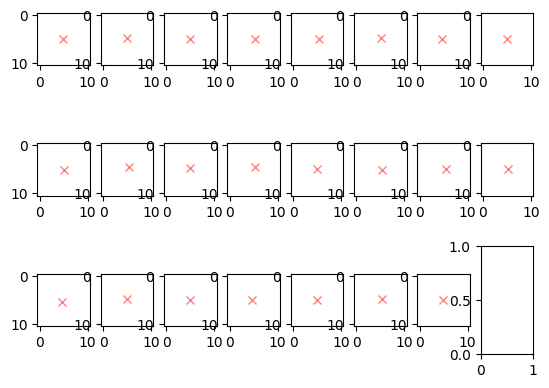

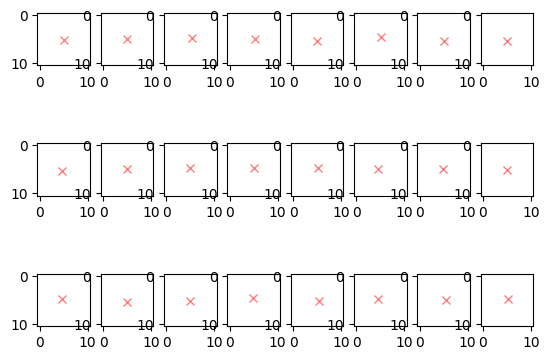

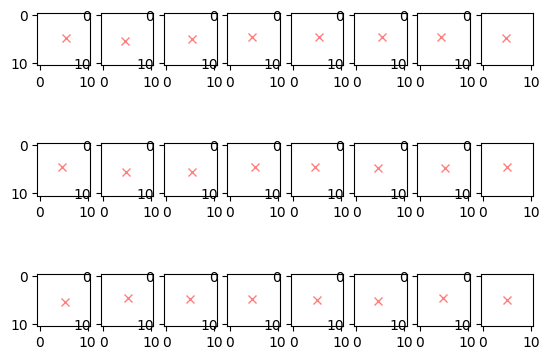

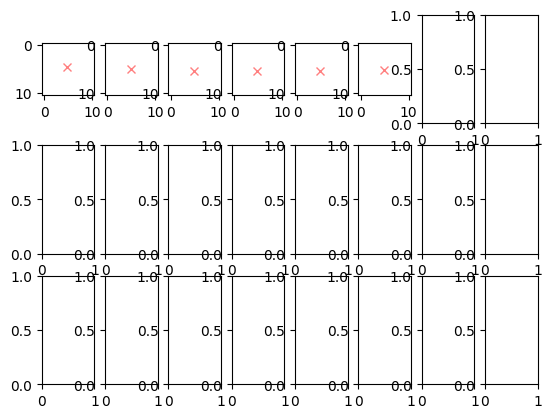

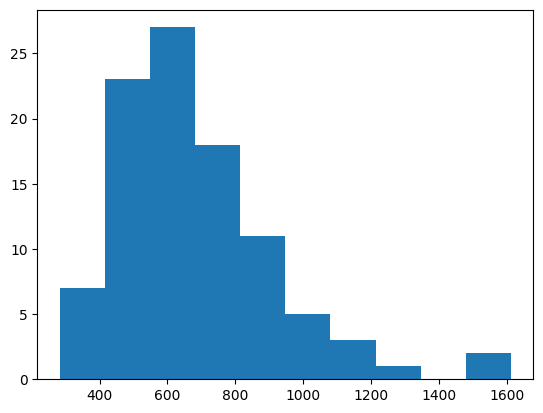

In [17]:
_,_,residual_intensity_arrays = draw_histograms_of_intensities(b_draw_slices = True,title="No Normalization")
plt.figure()
a = []
for b in residual_intensity_arrays:
    a += b
plt.hist(np.array(a).flatten())

Find Best Alpha For Normalization

In [18]:
if False:
    for i,alpha in tqdm.tqdm(enumerate(np.linspace(0.01,0.4,40))):
        normalization_quantiles = (alpha, 1 - alpha)
        load_images(normalization_quantiles)
        fig1,fig2,_ = draw_histograms_of_intensities(False,title=f"alpha={alpha:.3f}")
        try:
            os.mkdir("figures")
        except:
            pass
        fig1.savefig(f"figures1\\{i:03d}.png")
        fig2.savefig(f"figures2\\{i:03d}.png")

Filter Out Tagged Points Who's COM of their surrounding region is very far from the tagged point

In [19]:
def get_image_center_of_mass(sml_img):
    sml_img_normed = np.copy(sml_img)
    sml_img_normed -= np.quantile(sml_img_normed,0.05)
    sml_img_normed[sml_img_normed < 0] = 0
    sml_img_normed = sml_img_normed**4
    sml_img_normed /= np.mean(sml_img_normed)
    mean_sml_img = np.mean(sml_img_normed)
    x,y,z = np.meshgrid(np.arange(sml_img_normed.shape[0]),np.arange(sml_img_normed.shape[1]),np.arange(sml_img_normed.shape[2]),indexing="ij")
    xm,ym,zm = np.mean(sml_img_normed*x)/mean_sml_img,np.mean(sml_img_normed*y)/mean_sml_img,np.mean(sml_img_normed*z)/mean_sml_img
    return xm,ym,zm, sml_img_normed

Export images of spots to matlab file

42


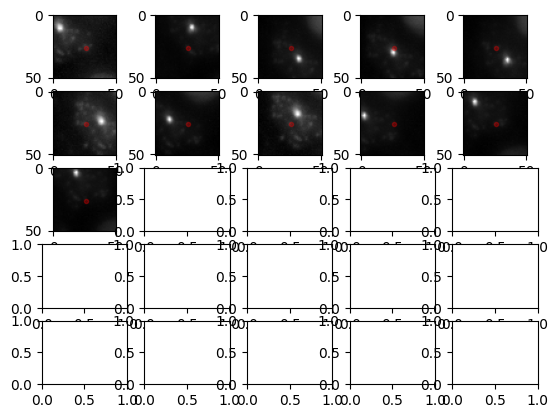

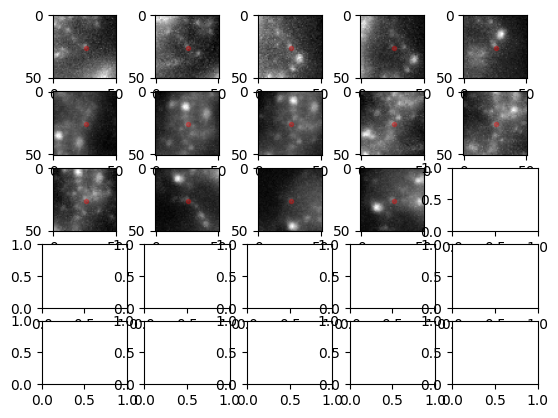

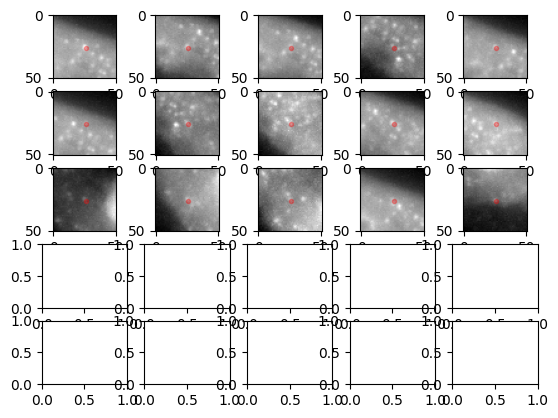

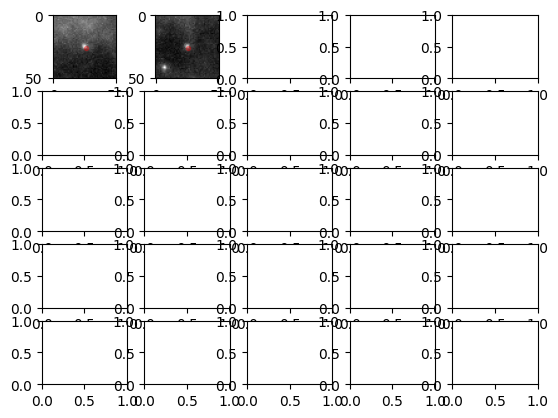

In [20]:
z_span = 2
xy_span = 25
spot_max_delta_xy = 2
spot_max_delta_z = 1
f = 0
images_dict = dict()
for i in range(len(images)):
    # sml_imges = np.full((tagged[i].shape[0],10,10,4),np.nan)
    sml_imges,sml_imges_point_loc = get_small_images_around_points(image_index=i,z_span=z_span+spot_max_delta_z,xy_span=xy_span+spot_max_delta_xy,assert_size=False)
    centers = []
    spot_imgs = []
    for sml_img in sml_imges:
        x,y,z = sml_img.shape[0]//2,sml_img.shape[1]//2,sml_img.shape[2]//2
        sz_xy,sz_z = spot_max_delta_xy,spot_max_delta_z
        spot_region = sml_img[x-sz_xy:x+sz_xy+1,y-sz_xy:y+sz_xy+1,z-sz_z:z+sz_z+1]
        xc,yc,zc = np.where(spot_region >= np.max(spot_region))
        xc = xc[0] + x - sz_xy
        yc = yc[0] + y - sz_xy
        zc = zc[0] + z - sz_z
        centers.append([xc,yc,zc])
        sz_xy,sz_z = xy_span,z_span
        spot_image = sml_img[xc-sz_xy:xc+sz_xy+1,yc-sz_xy:yc+sz_xy+1,zc-sz_z:zc+sz_z+1]
        if np.shape(spot_image) != (sz_xy*2+1,sz_xy*2+1,sz_z*2+1):
            continue
        spot_imgs.append(spot_image)
    images_dict[f"image_{i+1}"] = spot_imgs
    _,axes = plt.subplots(5,5)
    axes = axes.flatten()
    for j in range(len(axes)):
        if j >= len(spot_imgs):
            break
        spot_img = spot_imgs[j]
        axes[j].imshow(np.max(spot_img,axis=-1),cmap="gray")
        x,y,z = spot_img.shape[0]//2,spot_img.shape[1]//2,spot_img.shape[2]//2
        axes[j].plot(x+1,y+1,".r",alpha=0.3)
        f += 1
    
print(f)
# scipy.io.savemat("spots_images.mat",images_dict)
            